<a href="https://colab.research.google.com/github/BasseyIsrael/BasseyIsrael/blob/main/Choke_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
 !pip install ax-platform


In [7]:
!pip install geostatspy

In [8]:
!pip install shap

In [9]:
import pandas as pd                              # For data frame manipulation and calculations
import numpy as np                               # For array manipulation
import os
%matplotlib inline
import matplotlib.pyplot as plt                  # To view figures
import seaborn as sns                            # For matrix plot visualization
import pandas.plotting as pd_plot       # used in function for visualization
from scipy import stats                   # summary statistics
from scipy import linalg                  # for linear regression
import random                             # for randon numbers

import warnings
warnings.filterwarnings("ignore")

from scipy import linalg, stats                  # for linear regression and  summary statistics
from timeit import default_timer as timer        # to measure the time of the runs
import csv # to create csv files

import pandas as pd                              # For data frame manipulation and calculations
import numpy as np                               # For array manipulation
import os
%matplotlib inline
import matplotlib.pyplot as plt                  # To view figures
import seaborn as sns                            # For matrix plot visualization


import warnings
warnings.filterwarnings("ignore")

import shap
from tqdm import tqdm                            # progress meter that wraps around any iterable to determine % completion of program runnings.
from scipy import linalg, stats                  # for linear regression and  summary statistics
from timeit import default_timer as timer        # to measure the time of the runs
import csv # to create csv files
  

# import sklearn libraries for Modelling
from sklearn.decomposition import PCA   # for PCA
from sklearn.feature_selection import mutual_info_regression    #for Mutual Information
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler                            # standardize variables to mean of 0.0 and variance of 1.0
from sklearn.feature_selection import mutual_info_regression              # Bivariate relationship checker and feature importance check
from sklearn.model_selection import train_test_split, cross_validate      # For fair split of data into train and testing
from sklearn import tree                                  # tree program from scikit learn (package for machine learning)
from sklearn.tree import _tree                            # for accessing tree information
from sklearn import metrics                               # measures to check our models
from sklearn.model_selection import cross_val_score       # cross validation methods

# Ax - To understand, manage, deploy, and automate adaptive experiments/optimizations built in pytorch, known to effeectively handle noisy data.
from ax.service.ax_client import AxClient
from ax.utils.notebook.plotting import render, init_notebook_plotting

# plotly imports – To generate interactive plots in notebook
from plotly.offline import init_notebook_mode,iplot                       # Figure generation
import plotly.figure_factory as ff


import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python   

In [10]:
#The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from GeostatsGuy GitHub.

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_tree(tree,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    plt.figure(figsize=(8,6))
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    plt.show()
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Heat Rate'); plt.ylabel('Estimated Heat Rate')
    plt.xlim(0,1); plt.ylim(0,1)
    plt.arrow(0,0,1,1,width=0.001,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Testing = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

shap.initjs()

def shap_plot(inputs,df):
    
    """ This is used to visualize and interprete the contribution of predictor features to response for the entire data set.
    It can be used in both classification and regression models and serves not only as a visualization tool but can be repurposed for feature selection as well.
    
    Parameters
    inputs: is a ML model already instantiated with chosen hyperparameters as needed required for visualization
    df: is data frame consisting of predictors to be visualized compared to test data. # If only one observation is needed to be viewed, use df.iloc[2,:] 
    for specific row of 2.
    
    """

    model_explainer = shap.KernelExplainer(inputs.predict,df) # Predictions using Tuned Hyperparameters compared to test data
    model_shap_values = model_explainer.shap_values(df)
    p = shap.force_plot(model_explainer.expected_value,model_shap_values,df)    
    return p

**Loading Data**


In [11]:
df = pd.read_excel('/content/New Data.xlsx')

In [12]:
df2 = pd.DataFrame(df.describe().transpose())
df2

,count,mean,std,min,25%,50%,75%,max
ch_size,2333.0,28.102443,9.465667,8.000000,22.000000,26.000000,32.000000,48.000000
th_pres,2335.0,990.787929,608.142702,112.000000,515.500000,909.000000,1323.000000,2957.000000
ac_pres,2335.0,990.787929,608.142702,112.000000,515.500000,909.000000,1323.000000,2957.000000
line_pres,2335.0,137.578176,15.620556,54.955943,118.281943,142.988943,151.142943,155.423943
sf_pres,2335.0,4288.655222,1230.143145,204.592209,3719.353397,4392.854214,5209.467700,6454.299309
gas_prod,2122.0,6.285154,7.004591,0.000000,0.891812,3.777375,7.399135,25.131393
oil_prod,2334.0,22884.431105,33007.435568,0.000000,1076.250000,8790.500000,23593.500000,137556.840000
oil_gravity,2335.0,36.244283,3.207893,34.600000,34.600000,34.600000,34.600000,42.500000
wh_temp,2335.0,62.081370,4.060623,60.000000,60.000000,60.000000,60.000000,70.000000
gas_gravity,2335.0,0.974118,0.038007,0.900000,0.993600,0.993600,0.993600,0.993600


In [13]:
pd.DataFrame.to_csv(df2)
df.to_csv(r'C:\Users\PEGIS Global Admin\Desktop\Choke Performance\File Name.csv', index = False)



---


Production time is irrelevant to the analysis being made and the choke performance prediction, hence time column will be dropped from the dataset. 

The model development is based on the choke performance and the sandface pressure is a bottom hole attribute. For this reason, it can be safely assumed that the sandface pressre has no direct effect on the wellhead choke performance and it can be dropped from the dataset

Dropping other variables will be solely dependent on the result from the data analysis performend.

---




**Basic Data Checking and Visualization**

Here we perform some feature ranking/engineering methods to decide the predictor features to predict the response. This suffices as a qualitative check for problems in the data and assess each feature's confidence to avoid the curse of dimensionality during prediction.

In [14]:

# User specified min and max values, and labels for plotting
ch_sizemin = 8.; ch_sizemax = 48.; ch_sizename = 'Choke Size (64")'; ch_sizetitle = 'Choke Size Histogram'
th_presmin = 110; th_presmax = 3000.; th_presname = 'Tubing Head Pressure (psi)'; th_prestitle = 'Tubing Head Pressure'
ac_presmin = 110; ac_presmax =3000.; ac_presname = 'Active Pressure (PSI)'; ac_prestitle = 'Active Pressure'
line_presmin = 50.; line_presmax=160.; line_presname ='Line Pressure'; line_prestitle = 'Line Pressure'
sf_presmin = 200.; sf_presmax = 6500.; sf_presname='Sandface Pressure'; sf_prestitle ='Sandface Pressure'
gas_prodmin =0; gas_prodmax=26.; gas_prodname='Gas Production'; gas_prodtitle = 'Gas Production'
oil_prodmin =0; oil_prodmax=140000.; oil_prodname='Oil Production'; oil_prodtitle = 'Oil Production'
oil_gravitymin = 34; oil_gravitymax = 43.; oil_gravityname =' Oil Gravity (API)'; oil_gravitytitle = 'Oil Gravity'
gas_gravitymin = 0.9; gas_gravitymax = 1; gas_gravityname =' Gas Gravity'; gas_gravitytitle = 'gas Gravity'
wh_tempmin =60; wh_tempmax=70.; wh_tempname='Wellhead Temperature'; wh_temptitle = 'Wellhead Temperature'

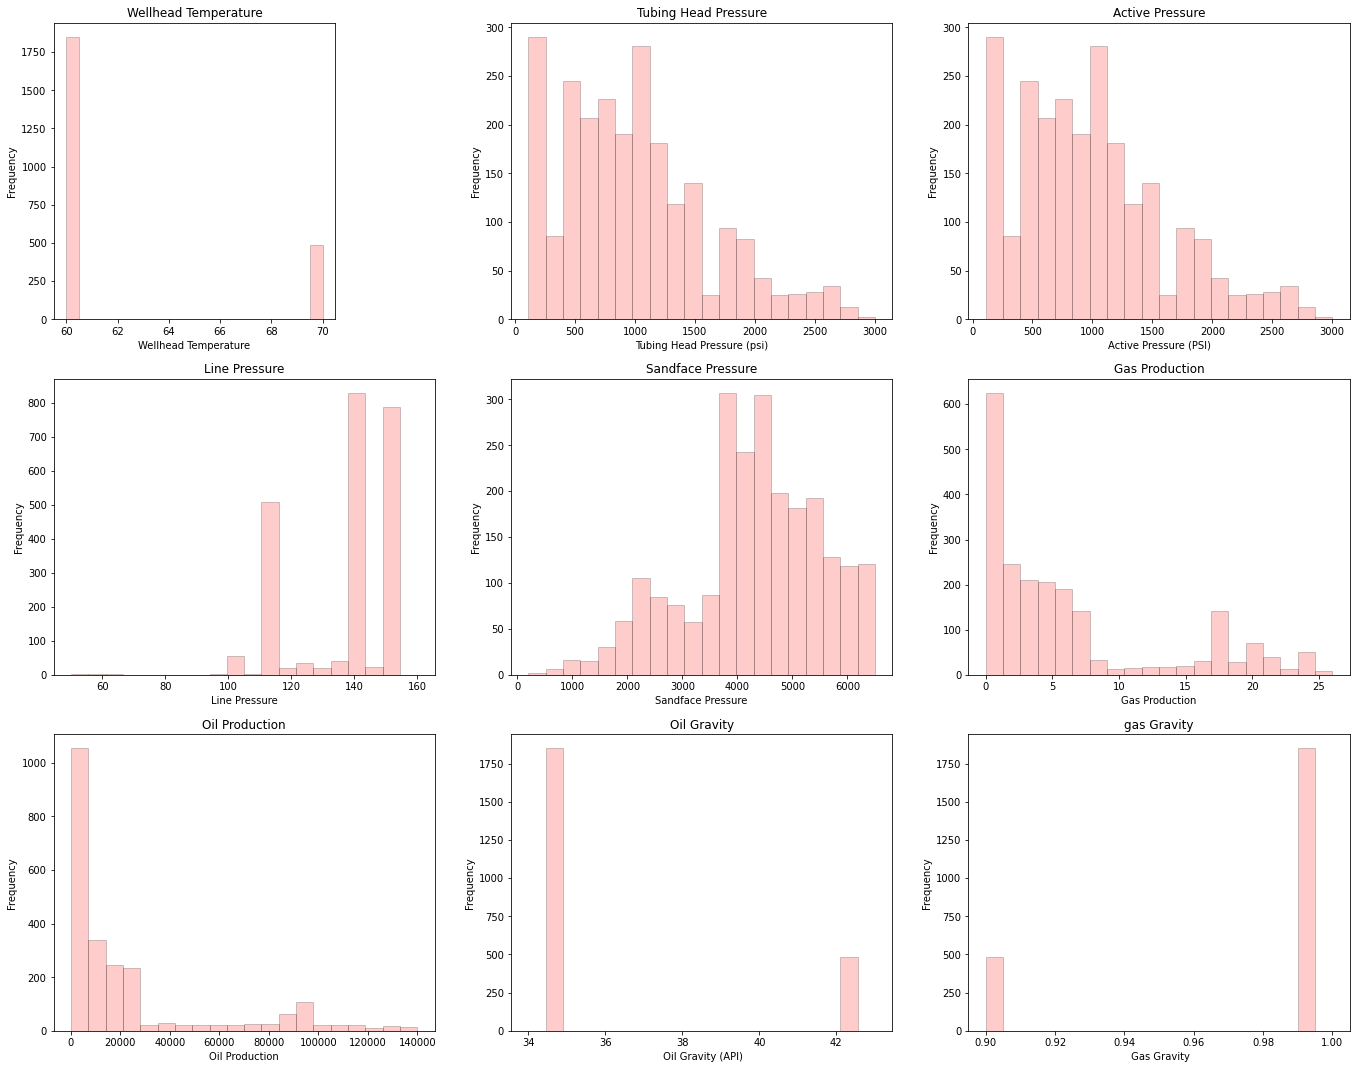

In [15]:
plt.subplot(331)
GSLIB.hist_st(df['ch_size'].values,
              ch_sizemin,ch_sizemax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=ch_sizename,
              title=ch_sizetitle)

plt.subplot(332)
GSLIB.hist_st(df['th_pres '].values,
              th_presmin,
              th_presmax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=th_presname,
              title=th_prestitle)

plt.subplot(333)
GSLIB.hist_st(df['ac_pres'].values,
              ac_presmin,
              ac_presmax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=ac_presname,
              title=ac_prestitle)

plt.subplot(334)
GSLIB.hist_st(df['line_pres '].values,
              line_presmin,
              line_presmax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=line_presname,
              title=line_prestitle)

plt.subplot(335)
GSLIB.hist_st(df['sf_pres'].values,
              sf_presmin,
              sf_presmax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=sf_presname,
              title=sf_prestitle)

plt.subplot(336)
GSLIB.hist_st(df['gas_prod'].values,
              gas_prodmin,
              gas_prodmax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=gas_prodname,
              title=gas_prodtitle)


plt.subplot(337)
GSLIB.hist_st(df['oil_prod'].values,
              oil_prodmin,
              oil_prodmax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=oil_prodname,
              title=oil_prodtitle)

plt.subplot(338)
GSLIB.hist_st(df['oil_gravity'].values,
              oil_gravitymin,
              oil_gravitymax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=oil_gravityname,
              title=oil_gravitytitle)

plt.subplot(339)
GSLIB.hist_st(df['gas_gravity'].values,
              gas_gravitymin,
              gas_gravitymax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=gas_gravityname,
              title=gas_gravitytitle)

plt.subplot(341)
GSLIB.hist_st(df['wh_temp'].values,
              wh_tempmin,
              wh_tempmax,
              log=False,
              cumul = False,
              bins=20,
              weights = None,
              xlabel=wh_tempname,
              title=wh_temptitle)


plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.5, wspace=0.2, hspace=0.2)
plt.show()

In [17]:
# Perform Pearson correlation between all features  
pcorrs = df.corr()

# Draw heat map
fig = ff.create_annotated_heatmap(
    z=pcorrs.values,
    x=list(pcorrs.columns),
    y=list(pcorrs.index),
    annotation_text=pcorrs.round(2).values,
    showscale=True, colorscale='viridis')

fig.update_layout(
    title="Correlation Matrix",
    width=1000,
    height =800,
    template='plotly_white',xaxis_tickangle=45
)

fig['layout']['xaxis']['side'] = 'bottom'

fig.show()

In [18]:
df = df.drop('ac_pres', axis = 1)

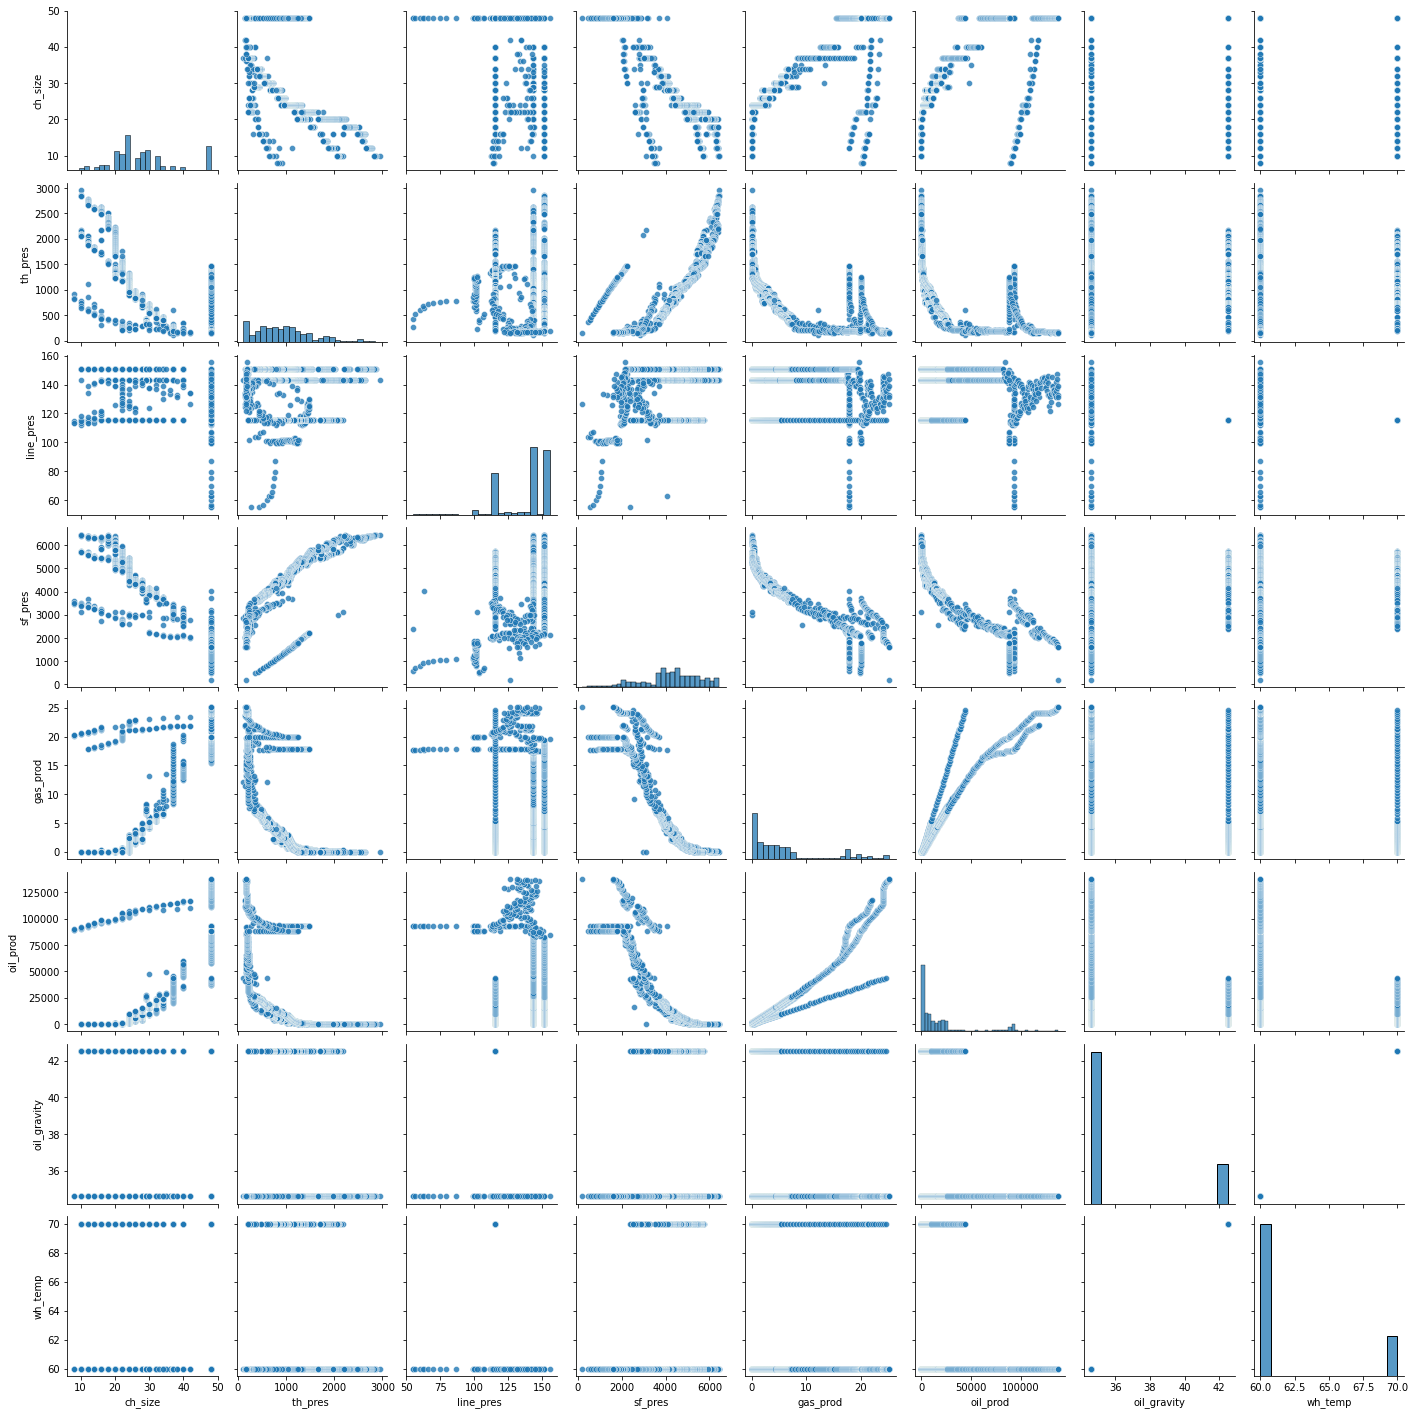

In [19]:
# Matrix scatter plot showing the bivariate relationship between variables
sns.pairplot(df,vars= df.iloc[:,:8],markers='o',kind='scatter', plot_kws={'alpha':0.8});

th_pres       -0.685811
line_pres     -0.108164
sf_pres       -0.891632
gas_prod       0.798260
oil_prod       0.753977
oil_gravity   -0.214863
wh_temp       -0.214863
Name: ch_size, dtype: float64


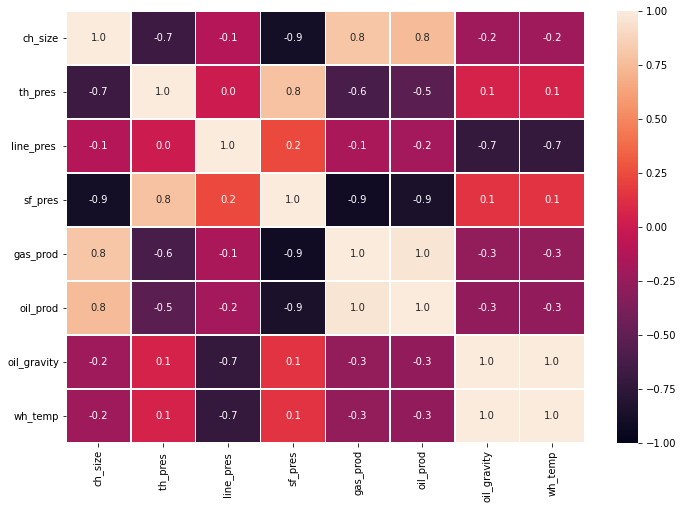

In [22]:
correlation = df.iloc[:,0:8].corr().iloc[0,1:8]
print(correlation)

plt.subplot(111)                          # plot a color coded correlation matrix
sns.heatmap(df.iloc[:,0:8].corr(),vmin = -1.0, vmax = 1.0,linewidths=.5, fmt= '.1f', annot= True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

In [21]:
norm_scaler = MinMaxScaler()                 
nfeatures = norm_scaler.fit_transform(df)          
df_n = pd.DataFrame(nfeatures,index=df.index)
df_n.columns = df.columns.copy()

In [23]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ch_size,2333.0,28.102443,9.465667,8.000000,22.000000,26.000000,32.000000,48.000000
th_pres,2335.0,990.787929,608.142702,112.000000,515.500000,909.000000,1323.000000,2957.000000
line_pres,2335.0,137.578176,15.620556,54.955943,118.281943,142.988943,151.142943,155.423943
sf_pres,2335.0,4288.655222,1230.143145,204.592209,3719.353397,4392.854214,5209.467700,6454.299309
gas_prod,2122.0,6.285154,7.004591,0.000000,0.891812,3.777375,7.399135,25.131393
oil_prod,2334.0,22884.431105,33007.435568,0.000000,1076.250000,8790.500000,23593.500000,137556.840000
oil_gravity,2335.0,36.244283,3.207893,34.600000,34.600000,34.600000,34.600000,42.500000
wh_temp,2335.0,62.081370,4.060623,60.000000,60.000000,60.000000,60.000000,70.000000
gas_gravity,2335.0,0.974118,0.038007,0.900000,0.993600,0.993600,0.993600,0.993600


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ch_size      2333 non-null   float64
 1   th_pres      2335 non-null   float64
 2   line_pres    2335 non-null   float64
 3   sf_pres      2335 non-null   float64
 4   gas_prod     2122 non-null   float64
 5   oil_prod     2334 non-null   float64
 6   oil_gravity  2335 non-null   float64
 7   wh_temp      2335 non-null   int64  
 8   gas_gravity  2335 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 164.3 KB


In [25]:
print(df.isnull().sum())

ch_size          2
th_pres          0
line_pres        0
sf_pres          0
gas_prod       213
oil_prod         1
oil_gravity      0
wh_temp          0
gas_gravity      0
dtype: int64


In [26]:
updated_df = df.dropna(axis=0)
y1 = updated_df['ch_size']
updated_df.drop("ch_size",axis=1,inplace=True)
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2120 entries, 0 to 2334
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   th_pres      2120 non-null   float64
 1   line_pres    2120 non-null   float64
 2   sf_pres      2120 non-null   float64
 3   gas_prod     2120 non-null   float64
 4   oil_prod     2120 non-null   float64
 5   oil_gravity  2120 non-null   float64
 6   wh_temp      2120 non-null   int64  
 7   gas_gravity  2120 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 149.1 KB


In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(updated_df,y1,test_size=0.3)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
print(metrics.r2_score(pred,y_test))

In [ ]:
oupdated_df = df.drop('gas_prod', axis=1)
oupdated_df = oupdated_df.dropna(axis=0)
y1 = oupdated_df['ch_size']
oupdated_df.drop("ch_size",axis=1,inplace=True)
oupdated_df.info()

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(oupdated_df,y1,test_size=0.3)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
print(metrics.r2_score(pred,y_test))

In [27]:
pupdated_df = df
pupdated_df['gas_prod']=pupdated_df['gas_prod'].fillna(pupdated_df['gas_prod'].mean())
pupdated_df['ch_size']=pupdated_df['ch_size'].fillna(pupdated_df['ch_size'].mean())
pupdated_df['oil_prod']=pupdated_df['oil_prod'].fillna(pupdated_df['oil_prod'].mean())
y3 = pupdated_df['ch_size']
pupdated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ch_size      2335 non-null   float64
 1   th_pres      2335 non-null   float64
 2   line_pres    2335 non-null   float64
 3   sf_pres      2335 non-null   float64
 4   gas_prod     2335 non-null   float64
 5   oil_prod     2335 non-null   float64
 6   oil_gravity  2335 non-null   float64
 7   wh_temp      2335 non-null   int64  
 8   gas_gravity  2335 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 164.3 KB


In [28]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(pupdated_df,y3,test_size=0.3)
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
print(metrics.r2_score(pred,y_test))

1.0


In [29]:
pupdated_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ch_size,2335.0,28.102443,9.461610,8.000000,22.000000,26.000000,32.000000,48.000000
th_pres,2335.0,990.787929,608.142702,112.000000,515.500000,909.000000,1323.000000,2957.000000
line_pres,2335.0,137.578176,15.620556,54.955943,118.281943,142.988943,151.142943,155.423943
sf_pres,2335.0,4288.655222,1230.143145,204.592209,3719.353397,4392.854214,5209.467700,6454.299309
gas_prod,2335.0,6.285154,6.677328,0.000000,1.113687,4.436750,6.910812,25.131393
oil_prod,2335.0,22884.431105,33000.363808,0.000000,1077.500000,8803.000000,23583.000000,137556.840000
oil_gravity,2335.0,36.244283,3.207893,34.600000,34.600000,34.600000,34.600000,42.500000
wh_temp,2335.0,62.081370,4.060623,60.000000,60.000000,60.000000,60.000000,70.000000
gas_gravity,2335.0,0.974118,0.038007,0.900000,0.993600,0.993600,0.993600,0.993600


In [32]:
norm_scaler = MinMaxScaler()                 
nfeatures = norm_scaler.fit_transform(pupdated_df)          
df_n = pd.DataFrame(nfeatures,index=df.index)
df_n.columns = df.columns.copy()
df_n.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ch_size,2335.0,0.502561,0.236540,0.0,0.350000,0.450000,0.600000,1.0
th_pres,2335.0,0.308889,0.213758,0.0,0.141828,0.280141,0.425659,1.0
line_pres,2335.0,0.822374,0.155478,0.0,0.630310,0.876229,0.957389,1.0
sf_pres,2335.0,0.653481,0.196832,0.0,0.562388,0.670153,0.800818,1.0
gas_prod,2335.0,0.250092,0.265697,0.0,0.044315,0.176542,0.274987,1.0
oil_prod,2335.0,0.166363,0.239903,0.0,0.007833,0.063995,0.171442,1.0
oil_gravity,2335.0,0.208137,0.406062,0.0,0.000000,0.000000,0.000000,1.0
wh_temp,2335.0,0.208137,0.406062,0.0,0.000000,0.000000,0.000000,1.0
gas_gravity,2335.0,0.791863,0.406062,0.0,1.000000,1.000000,1.000000,1.0


In [42]:
# Code for MI was obtained from Feature seleaction/Ranking Python Demo  by GeoStats Guy 
x = df_n.iloc[:,:8]              # separate DataFrames for predictor and response features
y = df_n.iloc[:,[8]]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=45)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=1., top=1., wspace=0.2, hspace=0.2)
plt.show()

IndexError: ignored

In [41]:
df_n = df_n.drop('line_pres', axis = 1)